Setup and Import Libraries

In [23]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Dropout, BatchNormalization, Add, Attention
from tensorflow.keras.optimizers import Adam

# Diffusion Model Imports
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Load and Filter Data

In [24]:
# Load the dataset
data = pd.read_csv('train.csv')

# Filter data for building_id = 1 and meter = 0
filtered_data = data[(data['building_id'] == 1) & (data['meter'] == 0)].copy()

# Convert timestamp to datetime and set as index
filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'])
filtered_data.set_index('timestamp', inplace=True)

# Select meter_reading as the target column
meter_reading = filtered_data['meter_reading'].values

# Normalize meter_reading between 0 and 1
min_val, max_val = meter_reading.min(), meter_reading.max()
meter_reading_normalized = (meter_reading - min_val) / (max_val - min_val)

print(f"Shape of filtered data: {filtered_data.shape}")

Shape of filtered data: (8784, 3)


Define Diffusion Model Parameters

In [25]:
# Diffusion Model Parameters
timesteps = 1000  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
beta = np.linspace(beta_start, beta_end, timesteps)
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)

# Noise scheduling
def add_noise(data, t, noise=None):
    if noise is None:
        noise = np.random.normal(size=data.shape)
    noisy_data = np.sqrt(alpha_bar[t]) * data + np.sqrt(1 - alpha_bar[t]) * noise
    return noisy_data, noise

Build the Diffusion Model (U-Net Style) for Time Series

In [26]:
# Define the improved LSTM-based Diffusion Model
def build_diffusion_model(seq_length):
    inputs = Input(shape=(seq_length, 1))
    
    # Encoder
    x = LSTM(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = LSTM(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Attention Layer
    attention = Attention()([x, x])
    x = Add()([x, attention])
    
    # Decoder
    x = LSTM(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = LSTM(128, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer to predict noise
    outputs = TimeDistributed(Dense(1))(x)
    
    model = Model(inputs, outputs)
    return model

# Define model parameters
seq_length = 24  # Length of time sequence
diffusion_model = build_diffusion_model(seq_length)
diffusion_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

Prepare Training Data for Diffusion Model

In [27]:
# Create overlapping sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + 1:i + 1 + seq_length])
    return np.array(X), np.array(y)

# Create training data
X_train, y_train = create_sequences(meter_reading_normalized, seq_length)

# Reshape for LSTM input
X_train = X_train.reshape(-1, seq_length, 1)
y_train = y_train.reshape(-1, seq_length, 1)

print(f"Training Data Shape: {X_train.shape}")

Training Data Shape: (8760, 24, 1)


Train the Diffusion Model

In [28]:
# Training loop for Diffusion Model
epochs = 50
batch_size = 32

# Train the model
history = diffusion_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 1.1798 - val_loss: 0.0108
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.3518 - val_loss: 0.0114
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.1185 - val_loss: 0.0067
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0392 - val_loss: 0.0072
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0159 - val_loss: 0.0070
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0092 - val_loss: 0.0072
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 9/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 10/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 11/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 12/50
247/247 ━━━━━━━━━━

Sampling New Synthetic Data Using Reverse Diffusion

  0%|          | 0/999 [00:00<?, ?it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


  0%|          | 1/999 [00:01<17:34,  1.06s/it]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 2/999 [00:01<09:53,  1.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 3/999 [00:01<07:23,  2.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 4/999 [00:01<06:10,  2.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  1%|          | 5/999 [00:02<05:30,  3.01it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  1%|          | 6/999 [00:02<05:11,  3.19it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 7/999 [00:02<05:02,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 8/999 [00:02<04:58,  3.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  1%|          | 9/999 [00:03<04:49,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 10/999 [00:03<04:55,  3.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 11/999 [00:03<04:54,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  1%|          | 12/999 [00:04<04:50,  3.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  1%|▏         | 13/999 [00:04<04:44,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|▏         | 14/999 [00:04<04:44,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 15/999 [00:05<04:47,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 16/999 [00:05<04:41,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  2%|▏         | 17/999 [00:05<04:39,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  2%|▏         | 18/999 [00:05<04:36,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  2%|▏         | 19/999 [00:06<04:30,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 20/999 [00:06<04:31,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 21/999 [00:06<04:33,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  2%|▏         | 22/999 [00:06<04:30,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 23/999 [00:07<04:36,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 24/999 [00:07<04:40,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 25/999 [00:07<04:39,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  3%|▎         | 26/999 [00:08<04:32,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 27/999 [00:08<04:32,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  3%|▎         | 28/999 [00:08<04:28,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 29/999 [00:08<04:30,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  3%|▎         | 30/999 [00:09<04:26,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 31/999 [00:09<04:29,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  3%|▎         | 32/999 [00:09<04:26,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 33/999 [00:10<04:25,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 34/999 [00:10<04:27,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  4%|▎         | 35/999 [00:10<04:25,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  4%|▎         | 36/999 [00:10<04:24,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  4%|▎         | 37/999 [00:11<04:24,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  4%|▍         | 38/999 [00:11<04:22,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 39/999 [00:11<04:30,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  4%|▍         | 40/999 [00:11<04:30,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  4%|▍         | 41/999 [00:12<04:25,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  4%|▍         | 42/999 [00:12<04:24,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  4%|▍         | 43/999 [00:12<04:22,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  4%|▍         | 44/999 [00:13<04:18,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▍         | 45/999 [00:13<04:18,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  5%|▍         | 46/999 [00:13<04:16,  3.71it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 47/999 [00:13<04:39,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|▍         | 48/999 [00:14<04:42,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▍         | 49/999 [00:14<04:37,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  5%|▌         | 50/999 [00:14<04:31,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|▌         | 51/999 [00:15<04:36,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▌         | 52/999 [00:15<04:35,  3.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▌         | 53/999 [00:15<04:32,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▌         | 54/999 [00:15<04:30,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 55/999 [00:16<04:28,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 56/999 [00:16<04:30,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  6%|▌         | 57/999 [00:16<04:23,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 58/999 [00:17<04:22,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  6%|▌         | 59/999 [00:17<04:20,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  6%|▌         | 60/999 [00:17<04:15,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 61/999 [00:17<04:15,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 62/999 [00:18<04:18,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▋         | 63/999 [00:18<04:19,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▋         | 64/999 [00:18<04:19,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 65/999 [00:18<04:16,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 66/999 [00:19<04:12,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 67/999 [00:19<04:11,  3.71it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 68/999 [00:19<04:09,  3.73it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 69/999 [00:20<04:09,  3.73it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|▋         | 70/999 [00:20<04:13,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|▋         | 71/999 [00:20<04:13,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 72/999 [00:20<04:11,  3.69it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 73/999 [00:21<04:12,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  7%|▋         | 74/999 [00:21<04:11,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  8%|▊         | 75/999 [00:21<04:10,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  8%|▊         | 76/999 [00:21<04:08,  3.71it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  8%|▊         | 77/999 [00:22<04:09,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 78/999 [00:22<04:12,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 79/999 [00:22<04:16,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 80/999 [00:23<04:17,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 81/999 [00:23<04:25,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  8%|▊         | 82/999 [00:23<04:21,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  8%|▊         | 83/999 [00:23<04:17,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 84/999 [00:24<04:16,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▊         | 85/999 [00:24<04:11,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▊         | 86/999 [00:24<04:08,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▊         | 87/999 [00:24<04:06,  3.71it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 88/999 [00:25<04:18,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▉         | 89/999 [00:25<04:14,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▉         | 90/999 [00:25<04:15,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  9%|▉         | 91/999 [00:26<04:08,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 92/999 [00:26<04:10,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▉         | 93/999 [00:26<04:09,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 94/999 [00:26<04:11,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|▉         | 95/999 [00:27<04:10,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 10%|▉         | 96/999 [00:27<04:08,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|▉         | 97/999 [00:27<04:06,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|▉         | 98/999 [00:28<04:03,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|▉         | 99/999 [00:28<04:00,  3.74it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|█         | 100/999 [00:28<03:59,  3.75it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|█         | 101/999 [00:28<04:01,  3.71it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 10%|█         | 102/999 [00:29<04:05,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|█         | 103/999 [00:29<04:05,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 10%|█         | 104/999 [00:29<04:03,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 11%|█         | 105/999 [00:29<04:02,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 11%|█         | 106/999 [00:30<03:57,  3.75it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 11%|█         | 107/999 [00:30<03:57,  3.75it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 11%|█         | 108/999 [00:30<03:56,  3.77it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|█         | 109/999 [00:31<04:02,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|█         | 110/999 [00:31<04:05,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|█         | 111/999 [00:31<04:06,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 112/999 [00:31<04:20,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|█▏        | 113/999 [00:32<04:18,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█▏        | 114/999 [00:32<04:21,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 115/999 [00:32<04:16,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 12%|█▏        | 116/999 [00:33<04:07,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 12%|█▏        | 117/999 [00:33<04:00,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 118/999 [00:33<04:05,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 119/999 [00:33<04:07,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 12%|█▏        | 120/999 [00:34<04:03,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 121/999 [00:34<04:03,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 12%|█▏        | 122/999 [00:34<04:00,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 123/999 [00:34<04:01,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 12%|█▏        | 124/999 [00:35<04:00,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 125/999 [00:35<04:00,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 126/999 [00:35<04:05,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 127/999 [00:36<04:06,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 13%|█▎        | 128/999 [00:36<04:03,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 13%|█▎        | 129/999 [00:36<04:01,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 13%|█▎        | 130/999 [00:36<03:58,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 13%|█▎        | 131/999 [00:37<03:57,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 132/999 [00:37<03:57,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 133/999 [00:37<03:57,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 134/999 [00:38<04:04,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▎        | 135/999 [00:38<04:04,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▎        | 136/999 [00:38<04:03,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 14%|█▎        | 137/999 [00:38<03:57,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▍        | 138/999 [00:39<03:58,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▍        | 139/999 [00:39<03:57,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▍        | 140/999 [00:39<03:57,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 14%|█▍        | 141/999 [00:39<03:57,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 142/999 [00:40<04:16,  3.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 14%|█▍        | 143/999 [00:40<04:14,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 14%|█▍        | 144/999 [00:40<04:07,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 15%|█▍        | 145/999 [00:41<04:00,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 146/999 [00:41<03:58,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 147/999 [00:41<04:00,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 148/999 [00:41<03:59,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 149/999 [00:42<04:01,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▌        | 150/999 [00:42<04:02,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 151/999 [00:42<04:08,  3.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 152/999 [00:43<04:15,  3.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 153/999 [00:43<04:17,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 154/999 [00:43<04:15,  3.30it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 155/999 [00:44<04:13,  3.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 156/999 [00:44<04:13,  3.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 157/999 [00:44<04:22,  3.20it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 158/999 [00:45<04:19,  3.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 159/999 [00:45<04:15,  3.29it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 160/999 [00:45<04:15,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 161/999 [00:45<04:16,  3.27it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 162/999 [00:46<04:20,  3.21it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▋        | 163/999 [00:46<04:23,  3.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▋        | 164/999 [00:46<04:31,  3.07it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 165/999 [00:47<04:30,  3.08it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 166/999 [00:47<04:37,  3.00it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 167/999 [00:47<04:31,  3.06it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 168/999 [00:48<04:23,  3.15it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 169/999 [00:48<04:18,  3.21it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 170/999 [00:48<04:14,  3.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 171/999 [00:49<04:19,  3.19it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 172/999 [00:49<04:19,  3.19it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 173/999 [00:49<04:17,  3.21it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 174/999 [00:50<04:21,  3.16it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 175/999 [00:50<04:19,  3.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 176/999 [00:50<04:15,  3.22it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 177/999 [00:51<04:13,  3.24it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 178/999 [00:51<04:22,  3.13it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 179/999 [00:51<04:17,  3.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 180/999 [00:51<04:13,  3.23it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 181/999 [00:52<04:11,  3.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 182/999 [00:52<04:12,  3.24it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 183/999 [00:52<04:10,  3.26it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 184/999 [00:53<04:06,  3.30it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▊        | 185/999 [00:53<04:04,  3.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▊        | 186/999 [00:53<03:59,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 19%|█▊        | 187/999 [00:54<03:53,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 188/999 [00:54<03:52,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 189/999 [00:54<03:51,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 190/999 [00:54<03:48,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 19%|█▉        | 191/999 [00:55<03:53,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 192/999 [00:55<04:03,  3.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 19%|█▉        | 193/999 [00:55<03:55,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 194/999 [00:56<03:54,  3.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|█▉        | 195/999 [00:56<03:50,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|█▉        | 196/999 [00:56<03:48,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 20%|█▉        | 197/999 [00:56<03:43,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|█▉        | 198/999 [00:57<03:45,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|█▉        | 199/999 [00:57<03:43,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|██        | 200/999 [00:57<03:46,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|██        | 201/999 [00:58<03:45,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|██        | 202/999 [00:58<03:42,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 20%|██        | 203/999 [00:58<03:42,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 20%|██        | 204/999 [00:58<03:41,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██        | 205/999 [00:59<03:37,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██        | 206/999 [00:59<03:36,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 207/999 [00:59<03:37,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 208/999 [00:59<03:39,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██        | 209/999 [01:00<03:39,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██        | 210/999 [01:00<03:37,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██        | 211/999 [01:00<03:36,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 212/999 [01:01<03:38,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██▏       | 213/999 [01:01<03:36,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 21%|██▏       | 214/999 [01:01<03:35,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 22%|██▏       | 215/999 [01:01<03:35,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 216/999 [01:02<03:38,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 217/999 [01:02<03:43,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 22%|██▏       | 218/999 [01:02<03:45,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 22%|██▏       | 219/999 [01:03<03:40,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 22%|██▏       | 220/999 [01:03<03:42,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 22%|██▏       | 221/999 [01:03<03:41,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 22%|██▏       | 222/999 [01:03<03:38,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 22%|██▏       | 223/999 [01:04<03:36,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 224/999 [01:04<03:50,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 225/999 [01:04<03:50,  3.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 226/999 [01:05<03:48,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 227/999 [01:05<03:47,  3.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 228/999 [01:05<03:44,  3.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 23%|██▎       | 229/999 [01:05<03:38,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 23%|██▎       | 230/999 [01:06<03:36,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 231/999 [01:06<03:38,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 23%|██▎       | 232/999 [01:06<03:35,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 23%|██▎       | 233/999 [01:07<03:32,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 23%|██▎       | 234/999 [01:07<03:32,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▎       | 235/999 [01:07<03:40,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▎       | 236/999 [01:07<03:36,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 24%|██▎       | 237/999 [01:08<03:33,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 24%|██▍       | 238/999 [01:08<03:29,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▍       | 239/999 [01:08<03:30,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 240/999 [01:09<03:46,  3.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▍       | 241/999 [01:09<03:45,  3.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 24%|██▍       | 242/999 [01:09<03:37,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 24%|██▍       | 243/999 [01:09<03:32,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▍       | 244/999 [01:10<03:29,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 25%|██▍       | 245/999 [01:10<03:25,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 25%|██▍       | 246/999 [01:10<03:26,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▍       | 247/999 [01:10<03:31,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 25%|██▍       | 248/999 [01:11<03:26,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▍       | 249/999 [01:11<03:31,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▌       | 250/999 [01:11<03:29,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 25%|██▌       | 251/999 [01:12<03:25,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▌       | 252/999 [01:12<03:27,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 25%|██▌       | 253/999 [01:12<03:27,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▌       | 254/999 [01:12<03:26,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 255/999 [01:13<03:31,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 256/999 [01:13<03:33,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 26%|██▌       | 257/999 [01:13<03:28,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 258/999 [01:14<03:30,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 259/999 [01:14<03:28,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 26%|██▌       | 260/999 [01:14<03:26,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 261/999 [01:14<03:26,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 262/999 [01:15<03:44,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▋       | 263/999 [01:15<03:57,  3.10it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▋       | 264/999 [01:15<03:52,  3.17it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 265/999 [01:16<03:44,  3.27it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 266/999 [01:16<03:40,  3.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 267/999 [01:16<03:32,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 268/999 [01:17<03:29,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 269/999 [01:17<03:25,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 270/999 [01:17<03:26,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 271/999 [01:17<03:22,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 272/999 [01:18<03:20,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 273/999 [01:18<03:19,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 27%|██▋       | 274/999 [01:18<03:17,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 28%|██▊       | 275/999 [01:18<03:20,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 28%|██▊       | 276/999 [01:19<03:18,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 28%|██▊       | 277/999 [01:19<03:15,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 28%|██▊       | 278/999 [01:19<03:16,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 28%|██▊       | 279/999 [01:20<03:15,  3.69it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 28%|██▊       | 280/999 [01:20<03:31,  3.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 281/999 [01:20<03:35,  3.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 282/999 [01:21<03:38,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 283/999 [01:21<03:40,  3.24it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 284/999 [01:21<03:49,  3.11it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▊       | 285/999 [01:22<03:55,  3.04it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▊       | 286/999 [01:22<03:51,  3.08it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▊       | 287/999 [01:22<04:00,  2.95it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 288/999 [01:23<04:06,  2.88it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 289/999 [01:23<04:13,  2.80it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 290/999 [01:23<04:15,  2.78it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 291/999 [01:24<04:11,  2.82it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 292/999 [01:24<04:07,  2.86it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 293/999 [01:24<03:56,  2.98it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 294/999 [01:25<03:56,  2.98it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██▉       | 295/999 [01:25<03:48,  3.08it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 296/999 [01:25<03:46,  3.10it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 297/999 [01:26<03:43,  3.14it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██▉       | 298/999 [01:26<03:41,  3.16it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 299/999 [01:26<03:56,  2.96it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 300/999 [01:27<03:48,  3.06it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 301/999 [01:27<03:40,  3.16it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 302/999 [01:27<03:36,  3.22it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 303/999 [01:27<03:39,  3.17it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 304/999 [01:28<03:37,  3.20it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 305/999 [01:28<03:40,  3.15it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 306/999 [01:28<03:42,  3.12it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███       | 307/999 [01:29<03:37,  3.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███       | 308/999 [01:29<03:34,  3.22it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 31%|███       | 309/999 [01:29<03:28,  3.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 31%|███       | 310/999 [01:30<03:23,  3.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███       | 311/999 [01:30<03:24,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 312/999 [01:30<03:35,  3.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███▏      | 313/999 [01:31<03:32,  3.23it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███▏      | 314/999 [01:31<03:36,  3.17it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 315/999 [01:31<03:40,  3.10it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 316/999 [01:32<03:40,  3.10it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 317/999 [01:32<03:47,  3.00it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 318/999 [01:32<03:46,  3.01it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 319/999 [01:33<03:42,  3.06it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 32%|███▏      | 320/999 [01:33<03:29,  3.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 32%|███▏      | 321/999 [01:33<03:20,  3.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 32%|███▏      | 322/999 [01:33<03:14,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 32%|███▏      | 323/999 [01:34<03:10,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 32%|███▏      | 324/999 [01:34<03:08,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 325/999 [01:34<03:07,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 326/999 [01:34<03:06,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 327/999 [01:35<03:06,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 328/999 [01:35<03:03,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 329/999 [01:35<03:02,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 330/999 [01:36<03:03,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 331/999 [01:36<03:03,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 332/999 [01:36<03:01,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 333/999 [01:36<03:04,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 33%|███▎      | 334/999 [01:37<03:02,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 335/999 [01:37<03:18,  3.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▎      | 336/999 [01:37<03:13,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▎      | 337/999 [01:38<03:11,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 34%|███▍      | 338/999 [01:38<03:08,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 34%|███▍      | 339/999 [01:38<03:05,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 34%|███▍      | 340/999 [01:38<03:03,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▍      | 341/999 [01:39<03:04,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▍      | 342/999 [01:39<03:04,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 34%|███▍      | 343/999 [01:39<03:03,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▍      | 344/999 [01:39<03:02,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▍      | 345/999 [01:40<03:00,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▍      | 346/999 [01:40<02:58,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▍      | 347/999 [01:40<02:58,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▍      | 348/999 [01:41<02:58,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▍      | 349/999 [01:41<02:56,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 350/999 [01:41<03:01,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▌      | 351/999 [01:41<03:00,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 352/999 [01:42<03:04,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 35%|███▌      | 353/999 [01:42<03:05,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 35%|███▌      | 354/999 [01:42<03:01,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 355/999 [01:43<03:00,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 36%|███▌      | 356/999 [01:43<02:58,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 36%|███▌      | 357/999 [01:43<02:56,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 358/999 [01:43<03:00,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 359/999 [01:44<03:00,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 360/999 [01:44<03:00,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 36%|███▌      | 361/999 [01:44<02:58,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 36%|███▌      | 362/999 [01:45<02:56,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▋      | 363/999 [01:45<02:56,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▋      | 364/999 [01:45<02:56,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 37%|███▋      | 365/999 [01:45<02:51,  3.69it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 37%|███▋      | 366/999 [01:46<02:55,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 37%|███▋      | 367/999 [01:46<02:54,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 368/999 [01:46<03:00,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 369/999 [01:47<03:07,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 37%|███▋      | 370/999 [01:47<03:06,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 37%|███▋      | 371/999 [01:47<02:59,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 37%|███▋      | 372/999 [01:47<02:56,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 37%|███▋      | 373/999 [01:48<02:55,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███▋      | 374/999 [01:48<02:59,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 375/999 [01:48<02:58,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 38%|███▊      | 376/999 [01:48<02:55,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 377/999 [01:49<02:55,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 378/999 [01:49<02:54,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 379/999 [01:49<02:53,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 38%|███▊      | 380/999 [01:50<02:52,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 381/999 [01:50<02:54,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 38%|███▊      | 382/999 [01:50<02:52,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 38%|███▊      | 383/999 [01:50<02:51,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 38%|███▊      | 384/999 [01:51<02:48,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 39%|███▊      | 385/999 [01:51<02:48,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 39%|███▊      | 386/999 [01:51<02:47,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 387/999 [01:52<02:53,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 388/999 [01:52<02:56,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 39%|███▉      | 389/999 [01:52<02:56,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 39%|███▉      | 390/999 [01:52<02:53,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 39%|███▉      | 391/999 [01:53<02:50,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 392/999 [01:53<02:53,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 39%|███▉      | 393/999 [01:53<02:53,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 39%|███▉      | 394/999 [01:54<02:50,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 40%|███▉      | 395/999 [01:54<02:48,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 40%|███▉      | 396/999 [01:54<02:46,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|███▉      | 397/999 [01:54<02:50,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|███▉      | 398/999 [01:55<02:55,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 40%|███▉      | 399/999 [01:55<02:53,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 40%|████      | 400/999 [01:55<02:47,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|████      | 401/999 [01:56<02:49,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 40%|████      | 402/999 [01:56<02:49,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 40%|████      | 403/999 [01:56<02:47,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 404/999 [01:56<02:56,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 405/999 [01:57<02:56,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 406/999 [01:57<02:54,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 41%|████      | 407/999 [01:57<02:50,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 408/999 [01:58<02:47,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 41%|████      | 409/999 [01:58<02:43,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 410/999 [01:58<02:46,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 41%|████      | 411/999 [01:58<02:44,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 412/999 [01:59<02:47,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████▏     | 413/999 [01:59<02:46,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████▏     | 414/999 [01:59<02:47,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 42%|████▏     | 415/999 [02:00<02:44,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 42%|████▏     | 416/999 [02:00<02:39,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 42%|████▏     | 417/999 [02:00<02:39,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 42%|████▏     | 418/999 [02:00<02:36,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 42%|████▏     | 419/999 [02:01<02:35,  3.72it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 420/999 [02:01<02:49,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 421/999 [02:01<02:52,  3.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|████▏     | 422/999 [02:02<02:49,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 42%|████▏     | 423/999 [02:02<02:44,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|████▏     | 424/999 [02:02<02:43,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 43%|████▎     | 425/999 [02:02<02:42,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 43%|████▎     | 426/999 [02:03<02:41,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 43%|████▎     | 427/999 [02:03<02:40,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 43%|████▎     | 428/999 [02:03<02:40,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 43%|████▎     | 429/999 [02:03<02:36,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 43%|████▎     | 430/999 [02:04<02:36,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 43%|████▎     | 431/999 [02:04<02:34,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 43%|████▎     | 432/999 [02:04<02:32,  3.73it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 43%|████▎     | 433/999 [02:05<02:34,  3.67it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 43%|████▎     | 434/999 [02:05<02:33,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▎     | 435/999 [02:05<02:42,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▎     | 436/999 [02:05<02:47,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 44%|████▎     | 437/999 [02:06<02:43,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 44%|████▍     | 438/999 [02:06<02:38,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 439/999 [02:06<02:39,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 44%|████▍     | 440/999 [02:07<02:37,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 441/999 [02:07<02:36,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 44%|████▍     | 442/999 [02:07<02:33,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 443/999 [02:07<02:37,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 444/999 [02:08<02:37,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▍     | 445/999 [02:08<02:36,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 45%|████▍     | 446/999 [02:08<02:34,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▍     | 447/999 [02:09<02:35,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 45%|████▍     | 448/999 [02:09<02:34,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▍     | 449/999 [02:09<02:33,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 450/999 [02:09<02:38,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 451/999 [02:10<02:43,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 452/999 [02:10<02:43,  3.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 453/999 [02:10<02:43,  3.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 45%|████▌     | 454/999 [02:11<02:37,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 46%|████▌     | 455/999 [02:11<02:33,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 46%|████▌     | 456/999 [02:11<02:31,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▌     | 457/999 [02:11<02:34,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▌     | 458/999 [02:12<02:36,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 459/999 [02:12<02:41,  3.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▌     | 460/999 [02:12<02:43,  3.30it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 461/999 [02:13<02:47,  3.22it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▌     | 462/999 [02:13<02:46,  3.22it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 46%|████▋     | 463/999 [02:13<02:38,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▋     | 464/999 [02:14<02:38,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 465/999 [02:14<02:37,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 466/999 [02:14<02:35,  3.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 467/999 [02:14<02:34,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 468/999 [02:15<02:33,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 469/999 [02:15<02:31,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 47%|████▋     | 470/999 [02:15<02:27,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 471/999 [02:16<02:28,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 47%|████▋     | 472/999 [02:16<02:24,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 47%|████▋     | 473/999 [02:16<02:22,  3.69it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 474/999 [02:16<02:25,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 475/999 [02:17<02:23,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 476/999 [02:17<02:23,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 477/999 [02:17<02:22,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 478/999 [02:17<02:31,  3.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 479/999 [02:18<02:29,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 480/999 [02:18<02:25,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 48%|████▊     | 481/999 [02:18<02:39,  3.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 482/999 [02:19<02:33,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 483/999 [02:19<02:27,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 48%|████▊     | 484/999 [02:19<02:24,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 49%|████▊     | 485/999 [02:19<02:23,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 49%|████▊     | 486/999 [02:20<02:22,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 49%|████▊     | 487/999 [02:20<02:23,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 49%|████▉     | 488/999 [02:20<02:20,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 49%|████▉     | 489/999 [02:21<02:20,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 49%|████▉     | 490/999 [02:21<02:23,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 49%|████▉     | 491/999 [02:21<02:23,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 49%|████▉     | 492/999 [02:21<02:24,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 493/999 [02:22<02:34,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 494/999 [02:22<02:34,  3.26it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|████▉     | 495/999 [02:22<02:31,  3.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|████▉     | 496/999 [02:23<02:30,  3.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|████▉     | 497/999 [02:23<02:29,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 50%|████▉     | 498/999 [02:23<02:25,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 50%|████▉     | 499/999 [02:24<02:22,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|█████     | 500/999 [02:24<02:20,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 50%|█████     | 501/999 [02:24<02:17,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 50%|█████     | 502/999 [02:24<02:16,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|█████     | 503/999 [02:25<02:17,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 50%|█████     | 504/999 [02:25<02:16,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████     | 505/999 [02:25<02:15,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████     | 506/999 [02:25<02:15,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████     | 507/999 [02:26<02:14,  3.66it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 51%|█████     | 508/999 [02:26<02:27,  3.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████     | 509/999 [02:26<02:23,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████     | 510/999 [02:27<02:19,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████     | 511/999 [02:27<02:16,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████▏    | 512/999 [02:27<02:15,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████▏    | 513/999 [02:27<02:14,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 51%|█████▏    | 514/999 [02:28<02:13,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 515/999 [02:28<02:12,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 516/999 [02:28<02:10,  3.69it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 52%|█████▏    | 517/999 [02:28<02:08,  3.74it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 518/999 [02:29<02:09,  3.72it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 519/999 [02:29<02:08,  3.73it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 520/999 [02:29<02:08,  3.71it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 521/999 [02:30<02:19,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 52%|█████▏    | 522/999 [02:30<02:19,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 523/999 [02:30<02:15,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 52%|█████▏    | 524/999 [02:30<02:13,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 53%|█████▎    | 525/999 [02:31<02:11,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 526/999 [02:31<02:11,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 53%|█████▎    | 527/999 [02:31<02:10,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 528/999 [02:32<02:10,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 529/999 [02:32<02:10,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 53%|█████▎    | 530/999 [02:32<02:07,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 53%|█████▎    | 531/999 [02:32<02:05,  3.73it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 532/999 [02:33<02:06,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 53%|█████▎    | 533/999 [02:33<02:05,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 534/999 [02:33<02:17,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 54%|█████▎    | 535/999 [02:34<02:14,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▎    | 536/999 [02:34<02:13,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▍    | 537/999 [02:34<02:12,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▍    | 538/999 [02:34<02:11,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▍    | 539/999 [02:35<02:10,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▍    | 540/999 [02:35<02:10,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 541/999 [02:35<02:12,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 54%|█████▍    | 542/999 [02:36<02:11,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▍    | 543/999 [02:36<02:09,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 544/999 [02:36<02:10,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 55%|█████▍    | 545/999 [02:36<02:09,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 55%|█████▍    | 546/999 [02:37<02:07,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 547/999 [02:37<02:13,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 55%|█████▍    | 548/999 [02:37<02:12,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 55%|█████▍    | 549/999 [02:38<02:09,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 55%|█████▌    | 550/999 [02:38<02:09,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|█████▌    | 551/999 [02:38<02:11,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 55%|█████▌    | 552/999 [02:38<02:08,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 55%|█████▌    | 553/999 [02:39<02:07,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 55%|█████▌    | 554/999 [02:39<02:05,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 555/999 [02:39<02:06,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 556/999 [02:40<02:06,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 557/999 [02:40<02:04,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 558/999 [02:40<02:05,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 559/999 [02:40<02:05,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 560/999 [02:41<02:09,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 561/999 [02:41<02:20,  3.12it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 56%|█████▋    | 562/999 [02:41<02:12,  3.29it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 56%|█████▋    | 563/999 [02:42<02:07,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 56%|█████▋    | 564/999 [02:42<02:03,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 565/999 [02:42<02:02,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 566/999 [02:42<01:59,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 567/999 [02:43<01:59,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 568/999 [02:43<01:58,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 569/999 [02:43<01:56,  3.68it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 570/999 [02:44<01:55,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 571/999 [02:44<01:55,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 572/999 [02:44<02:05,  3.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 573/999 [02:44<02:00,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 57%|█████▋    | 574/999 [02:45<02:00,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 575/999 [02:45<01:59,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 58%|█████▊    | 576/999 [02:45<01:58,  3.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 58%|█████▊    | 577/999 [02:46<01:55,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 578/999 [02:46<01:56,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 579/999 [02:46<01:58,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 58%|█████▊    | 580/999 [02:46<01:56,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 58%|█████▊    | 581/999 [02:47<01:54,  3.64it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 582/999 [02:47<01:56,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 583/999 [02:47<01:57,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 584/999 [02:48<02:05,  3.30it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▊    | 585/999 [02:48<02:03,  3.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▊    | 586/999 [02:48<02:01,  3.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 587/999 [02:48<02:00,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 59%|█████▉    | 588/999 [02:49<01:57,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 59%|█████▉    | 589/999 [02:49<01:55,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 590/999 [02:49<01:59,  3.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 591/999 [02:50<01:57,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 59%|█████▉    | 592/999 [02:50<01:55,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 593/999 [02:50<01:55,  3.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 59%|█████▉    | 594/999 [02:50<01:54,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 60%|█████▉    | 595/999 [02:51<01:52,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 596/999 [02:51<01:56,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 60%|█████▉    | 597/999 [02:51<01:56,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 60%|█████▉    | 598/999 [02:52<01:55,  3.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 60%|█████▉    | 599/999 [02:52<01:52,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 60%|██████    | 600/999 [02:52<01:51,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 601/999 [02:52<01:53,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 60%|██████    | 602/999 [02:53<01:52,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 60%|██████    | 603/999 [02:53<01:49,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 60%|██████    | 604/999 [02:53<01:50,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 61%|██████    | 605/999 [02:53<01:49,  3.59it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 61%|██████    | 606/999 [02:54<01:50,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 61%|██████    | 607/999 [02:54<01:47,  3.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 608/999 [02:54<01:56,  3.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 61%|██████    | 609/999 [02:55<01:55,  3.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 61%|██████    | 610/999 [02:55<01:52,  3.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 61%|██████    | 611/999 [02:55<01:49,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 61%|██████▏   | 612/999 [02:55<01:46,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 61%|██████▏   | 613/999 [02:56<01:46,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 61%|██████▏   | 614/999 [02:56<01:46,  3.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 62%|██████▏   | 615/999 [02:56<01:45,  3.65it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 62%|██████▏   | 616/999 [02:57<01:43,  3.70it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 62%|██████▏   | 617/999 [02:57<01:42,  3.72it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 62%|██████▏   | 618/999 [02:57<01:42,  3.73it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 62%|██████▏   | 619/999 [02:57<01:40,  3.77it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 620/999 [02:58<01:50,  3.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 621/999 [02:58<01:50,  3.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 622/999 [02:58<01:48,  3.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 623/999 [02:59<01:47,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 624/999 [02:59<01:47,  3.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 63%|██████▎   | 625/999 [02:59<01:46,  3.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 63%|██████▎   | 626/999 [02:59<01:46,  3.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 63%|██████▎   | 627/999 [03:00<01:46,  3.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 63%|██████▎   | 628/999 [03:00<01:44,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 63%|██████▎   | 629/999 [03:00<01:44,  3.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 63%|██████▎   | 630/999 [03:01<01:43,  3.56it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 63%|██████▎   | 631/999 [03:01<01:43,  3.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 632/999 [03:01<01:49,  3.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 63%|██████▎   | 633/999 [03:01<01:44,  3.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 63%|██████▎   | 634/999 [03:02<01:42,  3.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 64%|██████▎   | 635/999 [03:02<01:41,  3.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 64%|██████▎   | 636/999 [03:02<01:40,  3.61it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 637/999 [03:03<01:46,  3.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 638/999 [03:03<01:50,  3.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 639/999 [03:03<01:50,  3.26it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 64%|██████▍   | 640/999 [03:04<01:50,  3.25it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 64%|██████▍   | 641/999 [03:04<01:49,  3.27it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 642/999 [03:04<01:50,  3.23it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 643/999 [03:04<01:51,  3.19it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 644/999 [03:05<01:56,  3.05it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▍   | 645/999 [03:05<01:52,  3.13it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 646/999 [03:05<01:51,  3.16it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 647/999 [03:06<01:52,  3.14it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▍   | 648/999 [03:06<01:50,  3.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▍   | 649/999 [03:06<01:48,  3.24it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 650/999 [03:07<01:48,  3.22it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 651/999 [03:07<01:51,  3.13it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 652/999 [03:07<01:53,  3.07it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 653/999 [03:08<01:57,  2.95it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 654/999 [03:08<02:02,  2.81it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 66%|██████▌   | 655/999 [03:09<02:10,  2.63it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|██████▌   | 656/999 [03:09<02:26,  2.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 657/999 [03:09<02:20,  2.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 658/999 [03:10<02:14,  2.54it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 659/999 [03:10<02:04,  2.74it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 660/999 [03:10<01:58,  2.86it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 661/999 [03:11<01:54,  2.95it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▋   | 662/999 [03:11<01:50,  3.06it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▋   | 663/999 [03:11<01:50,  3.03it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▋   | 664/999 [03:12<01:50,  3.04it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 665/999 [03:12<01:58,  2.81it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 666/999 [03:12<01:57,  2.85it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


 67%|██████▋   | 667/999 [03:13<02:48,  1.97it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 67%|██████▋   | 668/999 [03:14<02:56,  1.88it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 67%|██████▋   | 669/999 [03:15<03:02,  1.81it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 67%|██████▋   | 670/999 [03:15<03:06,  1.77it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 67%|██████▋   | 671/999 [03:16<03:25,  1.60it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 67%|██████▋   | 672/999 [03:17<03:26,  1.58it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 67%|██████▋   | 673/999 [03:17<03:20,  1.62it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 67%|██████▋   | 674/999 [03:18<03:33,  1.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 68%|██████▊   | 675/999 [03:18<03:26,  1.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 68%|██████▊   | 676/999 [03:19<03:25,  1.57it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 68%|██████▊   | 677/999 [03:20<03:38,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 68%|██████▊   | 678/999 [03:21<03:47,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 68%|██████▊   | 679/999 [03:21<03:45,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 68%|██████▊   | 680/999 [03:22<03:51,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 68%|██████▊   | 681/999 [03:23<03:57,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 68%|██████▊   | 682/999 [03:24<03:58,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 68%|██████▊   | 683/999 [03:24<03:45,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 68%|██████▊   | 684/999 [03:25<03:34,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 69%|██████▊   | 685/999 [03:26<03:29,  1.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 69%|██████▊   | 686/999 [03:26<03:38,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 69%|██████▉   | 687/999 [03:27<03:46,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 69%|██████▉   | 688/999 [03:28<03:37,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 69%|██████▉   | 689/999 [03:28<03:33,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 69%|██████▉   | 690/999 [03:29<03:41,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 69%|██████▉   | 691/999 [03:30<03:45,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 69%|██████▉   | 692/999 [03:31<03:48,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 69%|██████▉   | 693/999 [03:31<03:37,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 69%|██████▉   | 694/999 [03:32<03:29,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 70%|██████▉   | 695/999 [03:33<03:35,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 70%|██████▉   | 696/999 [03:33<03:26,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 70%|██████▉   | 697/999 [03:34<03:33,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 70%|██████▉   | 698/999 [03:35<03:40,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 70%|██████▉   | 699/999 [03:36<03:33,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 70%|███████   | 700/999 [03:36<03:30,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 70%|███████   | 701/999 [03:37<03:26,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 70%|███████   | 702/999 [03:38<03:34,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 70%|███████   | 703/999 [03:39<03:39,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 70%|███████   | 704/999 [03:39<03:30,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 71%|███████   | 705/999 [03:40<03:33,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 71%|███████   | 706/999 [03:41<03:36,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 71%|███████   | 707/999 [03:41<03:30,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 71%|███████   | 708/999 [03:42<03:26,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 71%|███████   | 709/999 [03:43<03:30,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 71%|███████   | 710/999 [03:43<03:27,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 71%|███████   | 711/999 [03:44<03:30,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 71%|███████▏  | 712/999 [03:45<03:22,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 71%|███████▏  | 713/999 [03:46<03:27,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 71%|███████▏  | 714/999 [03:46<03:18,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 72%|███████▏  | 715/999 [03:47<03:09,  1.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 72%|███████▏  | 716/999 [03:48<03:04,  1.53it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 72%|███████▏  | 717/999 [03:48<03:14,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 72%|███████▏  | 718/999 [03:49<03:07,  1.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 72%|███████▏  | 719/999 [03:50<03:24,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 72%|███████▏  | 720/999 [03:50<03:17,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 72%|███████▏  | 721/999 [03:51<03:11,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 72%|███████▏  | 722/999 [03:52<03:03,  1.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 72%|███████▏  | 723/999 [03:52<03:11,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 72%|███████▏  | 724/999 [03:53<03:07,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 73%|███████▎  | 725/999 [03:54<03:13,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 73%|███████▎  | 726/999 [03:55<03:15,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 73%|███████▎  | 727/999 [03:55<03:10,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 73%|███████▎  | 728/999 [03:56<03:07,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 73%|███████▎  | 729/999 [03:57<03:14,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 73%|███████▎  | 730/999 [03:58<03:18,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 73%|███████▎  | 731/999 [03:58<03:21,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 73%|███████▎  | 732/999 [03:59<03:12,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 73%|███████▎  | 733/999 [04:00<03:15,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 73%|███████▎  | 734/999 [04:00<03:17,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 74%|███████▎  | 735/999 [04:01<03:18,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 74%|███████▎  | 736/999 [04:02<03:13,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 74%|███████▍  | 737/999 [04:03<03:11,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 74%|███████▍  | 738/999 [04:03<03:07,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 74%|███████▍  | 739/999 [04:04<03:11,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 74%|███████▍  | 740/999 [04:05<03:12,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 74%|███████▍  | 741/999 [04:06<03:15,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 74%|███████▍  | 742/999 [04:06<03:07,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 74%|███████▍  | 743/999 [04:07<03:07,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 74%|███████▍  | 744/999 [04:08<02:59,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 75%|███████▍  | 745/999 [04:08<02:52,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 75%|███████▍  | 746/999 [04:09<02:59,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 75%|███████▍  | 747/999 [04:10<03:02,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 75%|███████▍  | 748/999 [04:11<03:03,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 75%|███████▍  | 749/999 [04:11<02:52,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 75%|███████▌  | 750/999 [04:12<02:58,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 75%|███████▌  | 751/999 [04:13<03:02,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 75%|███████▌  | 752/999 [04:14<03:05,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 75%|███████▌  | 753/999 [04:14<02:57,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 75%|███████▌  | 754/999 [04:15<02:49,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 76%|███████▌  | 755/999 [04:16<02:54,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 76%|███████▌  | 756/999 [04:16<02:52,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 76%|███████▌  | 757/999 [04:17<02:56,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 76%|███████▌  | 758/999 [04:18<02:58,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 76%|███████▌  | 759/999 [04:19<02:52,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 76%|███████▌  | 760/999 [04:19<02:52,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 76%|███████▌  | 761/999 [04:20<02:46,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 76%|███████▋  | 762/999 [04:21<02:41,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


 76%|███████▋  | 763/999 [04:21<02:44,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 76%|███████▋  | 764/999 [04:22<02:48,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 77%|███████▋  | 765/999 [04:23<02:43,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 77%|███████▋  | 766/999 [04:23<02:38,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 77%|███████▋  | 767/999 [04:24<02:43,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 77%|███████▋  | 768/999 [04:25<02:47,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 77%|███████▋  | 769/999 [04:26<02:51,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 77%|███████▋  | 770/999 [04:26<02:46,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 77%|███████▋  | 771/999 [04:27<02:48,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 77%|███████▋  | 772/999 [04:28<02:50,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 77%|███████▋  | 773/999 [04:29<02:41,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 77%|███████▋  | 774/999 [04:29<02:39,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 78%|███████▊  | 775/999 [04:30<02:42,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 78%|███████▊  | 776/999 [04:31<02:36,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 78%|███████▊  | 777/999 [04:31<02:40,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 78%|███████▊  | 778/999 [04:32<02:42,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 78%|███████▊  | 779/999 [04:33<02:36,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 78%|███████▊  | 780/999 [04:33<02:33,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 78%|███████▊  | 781/999 [04:34<02:27,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 78%|███████▊  | 782/999 [04:35<02:32,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 78%|███████▊  | 783/999 [04:36<02:29,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 78%|███████▊  | 784/999 [04:36<02:32,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 79%|███████▊  | 785/999 [04:37<02:36,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 79%|███████▊  | 786/999 [04:38<02:39,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 79%|███████▉  | 787/999 [04:39<02:39,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


 79%|███████▉  | 788/999 [04:39<02:40,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 79%|███████▉  | 789/999 [04:40<02:38,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 79%|███████▉  | 790/999 [04:41<02:31,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 79%|███████▉  | 791/999 [04:42<02:33,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 79%|███████▉  | 792/999 [04:42<02:36,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 79%|███████▉  | 793/999 [04:43<02:31,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 79%|███████▉  | 794/999 [04:44<02:23,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 80%|███████▉  | 795/999 [04:44<02:18,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 80%|███████▉  | 796/999 [04:45<02:24,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 80%|███████▉  | 797/999 [04:46<02:27,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 80%|███████▉  | 798/999 [04:46<02:20,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 80%|███████▉  | 799/999 [04:47<02:23,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 80%|████████  | 800/999 [04:48<02:19,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 80%|████████  | 801/999 [04:49<02:12,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 80%|████████  | 802/999 [04:49<02:17,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 80%|████████  | 803/999 [04:50<02:20,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 80%|████████  | 804/999 [04:51<02:16,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 81%|████████  | 805/999 [04:51<02:13,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 81%|████████  | 806/999 [04:52<02:23,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 81%|████████  | 807/999 [04:53<02:17,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 81%|████████  | 808/999 [04:53<02:11,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 81%|████████  | 809/999 [04:54<02:14,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 81%|████████  | 810/999 [04:55<02:17,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 81%|████████  | 811/999 [04:56<02:18,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 81%|████████▏ | 812/999 [04:57<02:19,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 81%|████████▏ | 813/999 [04:57<02:13,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 81%|████████▏ | 814/999 [04:58<02:20,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 82%|████████▏ | 815/999 [04:59<02:20,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 82%|████████▏ | 816/999 [04:59<02:13,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 82%|████████▏ | 817/999 [05:00<02:14,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 82%|████████▏ | 818/999 [05:01<02:09,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 82%|████████▏ | 819/999 [05:02<02:06,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 82%|████████▏ | 820/999 [05:02<02:06,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 82%|████████▏ | 821/999 [05:03<02:08,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 82%|████████▏ | 822/999 [05:04<02:06,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 82%|████████▏ | 823/999 [05:05<02:08,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 82%|████████▏ | 824/999 [05:05<02:05,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 83%|████████▎ | 825/999 [05:06<02:06,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 83%|████████▎ | 826/999 [05:07<02:07,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 83%|████████▎ | 827/999 [05:07<02:09,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 83%|████████▎ | 828/999 [05:08<02:04,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 83%|████████▎ | 829/999 [05:09<01:57,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 83%|████████▎ | 830/999 [05:09<01:53,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 83%|████████▎ | 831/999 [05:10<01:57,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 83%|████████▎ | 832/999 [05:11<01:56,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 83%|████████▎ | 833/999 [05:11<01:51,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 83%|████████▎ | 834/999 [05:12<01:50,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 84%|████████▎ | 835/999 [05:13<01:47,  1.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 84%|████████▎ | 836/999 [05:13<01:47,  1.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 84%|████████▍ | 837/999 [05:14<01:48,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 84%|████████▍ | 838/999 [05:15<01:46,  1.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 84%|████████▍ | 839/999 [05:16<01:49,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 84%|████████▍ | 840/999 [05:16<01:50,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 84%|████████▍ | 841/999 [05:17<01:49,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 84%|████████▍ | 842/999 [05:18<01:52,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 84%|████████▍ | 843/999 [05:18<01:49,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 84%|████████▍ | 844/999 [05:19<01:51,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 85%|████████▍ | 845/999 [05:20<01:52,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 85%|████████▍ | 846/999 [05:21<01:50,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 85%|████████▍ | 847/999 [05:21<01:49,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 85%|████████▍ | 848/999 [05:22<01:50,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 85%|████████▍ | 849/999 [05:23<01:51,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 85%|████████▌ | 850/999 [05:24<01:52,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 85%|████████▌ | 851/999 [05:24<01:52,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 85%|████████▌ | 852/999 [05:25<01:46,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 85%|████████▌ | 853/999 [05:26<01:47,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 85%|████████▌ | 854/999 [05:26<01:41,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 86%|████████▌ | 855/999 [05:27<01:38,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 86%|████████▌ | 856/999 [05:28<01:41,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 86%|████████▌ | 857/999 [05:28<01:36,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 86%|████████▌ | 858/999 [05:29<01:39,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


 86%|████████▌ | 859/999 [05:30<01:42,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 86%|████████▌ | 860/999 [05:31<01:38,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 86%|████████▌ | 861/999 [05:31<01:40,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 86%|████████▋ | 862/999 [05:32<01:39,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 86%|████████▋ | 863/999 [05:33<01:34,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 86%|████████▋ | 864/999 [05:33<01:32,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 87%|████████▋ | 865/999 [05:34<01:34,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 87%|████████▋ | 866/999 [05:35<01:36,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 87%|████████▋ | 867/999 [05:36<01:37,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 87%|████████▋ | 868/999 [05:36<01:34,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 87%|████████▋ | 869/999 [05:37<01:32,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 87%|████████▋ | 870/999 [05:38<01:32,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 87%|████████▋ | 871/999 [05:38<01:29,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 87%|████████▋ | 872/999 [05:39<01:31,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 87%|████████▋ | 873/999 [05:40<01:32,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 87%|████████▋ | 874/999 [05:41<01:28,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 88%|████████▊ | 875/999 [05:41<01:29,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 88%|████████▊ | 876/999 [05:42<01:27,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 88%|████████▊ | 877/999 [05:43<01:24,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 88%|████████▊ | 878/999 [05:43<01:26,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 88%|████████▊ | 879/999 [05:44<01:27,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 88%|████████▊ | 880/999 [05:45<01:24,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 88%|████████▊ | 881/999 [05:46<01:19,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 88%|████████▊ | 882/999 [05:46<01:18,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 88%|████████▊ | 883/999 [05:48<01:49,  1.06it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 88%|████████▊ | 884/999 [05:48<01:37,  1.18it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 89%|████████▊ | 885/999 [05:49<01:32,  1.23it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 89%|████████▊ | 886/999 [05:50<01:29,  1.26it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 89%|████████▉ | 887/999 [05:51<01:28,  1.27it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 89%|████████▉ | 888/999 [05:51<01:26,  1.28it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 89%|████████▉ | 889/999 [05:52<01:21,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 89%|████████▉ | 890/999 [05:53<01:22,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 89%|████████▉ | 891/999 [05:54<01:21,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 89%|████████▉ | 892/999 [05:54<01:20,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 89%|████████▉ | 893/999 [05:55<01:17,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 89%|████████▉ | 894/999 [05:56<01:18,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 90%|████████▉ | 895/999 [05:56<01:15,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 90%|████████▉ | 896/999 [05:57<01:14,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 90%|████████▉ | 897/999 [05:58<01:14,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 90%|████████▉ | 898/999 [05:59<01:12,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 90%|████████▉ | 899/999 [05:59<01:10,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 90%|█████████ | 900/999 [06:00<01:11,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 90%|█████████ | 901/999 [06:01<01:12,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 90%|█████████ | 902/999 [06:02<01:09,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


 90%|█████████ | 903/999 [06:02<01:10,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 90%|█████████ | 904/999 [06:03<01:10,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 91%|█████████ | 905/999 [06:04<01:08,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 91%|█████████ | 906/999 [06:04<01:06,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 91%|█████████ | 907/999 [06:05<01:03,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 91%|█████████ | 908/999 [06:06<01:01,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 91%|█████████ | 909/999 [06:06<01:03,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


 91%|█████████ | 910/999 [06:07<01:04,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 91%|█████████ | 911/999 [06:08<01:01,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 91%|█████████▏| 912/999 [06:09<01:02,  1.39it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 91%|█████████▏| 913/999 [06:09<01:02,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 91%|█████████▏| 914/999 [06:10<01:03,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 92%|█████████▏| 915/999 [06:11<01:02,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 92%|█████████▏| 916/999 [06:12<01:02,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 92%|█████████▏| 917/999 [06:12<01:01,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 92%|█████████▏| 918/999 [06:13<01:00,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 92%|█████████▏| 919/999 [06:14<01:00,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 92%|█████████▏| 920/999 [06:15<00:59,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 92%|█████████▏| 921/999 [06:15<00:59,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 92%|█████████▏| 922/999 [06:16<00:58,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 92%|█████████▏| 923/999 [06:17<00:58,  1.30it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 92%|█████████▏| 924/999 [06:18<00:58,  1.29it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 93%|█████████▎| 925/999 [06:19<00:57,  1.30it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 93%|█████████▎| 926/999 [06:19<00:52,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 93%|█████████▎| 927/999 [06:20<00:52,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 93%|█████████▎| 928/999 [06:21<00:51,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 93%|█████████▎| 929/999 [06:21<00:49,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 93%|█████████▎| 930/999 [06:22<00:46,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 93%|█████████▎| 931/999 [06:23<00:46,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 93%|█████████▎| 932/999 [06:23<00:47,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 93%|█████████▎| 933/999 [06:24<00:45,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


 93%|█████████▎| 934/999 [06:25<00:46,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 94%|█████████▎| 935/999 [06:26<00:47,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 94%|█████████▎| 936/999 [06:26<00:47,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 94%|█████████▍| 937/999 [06:27<00:46,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 94%|█████████▍| 938/999 [06:28<00:45,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 94%|█████████▍| 939/999 [06:29<00:45,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 94%|█████████▍| 940/999 [06:29<00:42,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 94%|█████████▍| 941/999 [06:30<00:42,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 94%|█████████▍| 942/999 [06:31<00:42,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 94%|█████████▍| 943/999 [06:32<00:42,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 94%|█████████▍| 944/999 [06:32<00:39,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 95%|█████████▍| 945/999 [06:33<00:38,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 95%|█████████▍| 946/999 [06:34<00:36,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 95%|█████████▍| 947/999 [06:34<00:35,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 95%|█████████▍| 948/999 [06:35<00:35,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 95%|█████████▍| 949/999 [06:36<00:33,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 95%|█████████▌| 950/999 [06:36<00:34,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 95%|█████████▌| 951/999 [06:37<00:32,  1.48it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 95%|█████████▌| 952/999 [06:38<00:32,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 95%|█████████▌| 953/999 [06:38<00:32,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 95%|█████████▌| 954/999 [06:39<00:31,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 96%|█████████▌| 955/999 [06:40<00:30,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 96%|█████████▌| 956/999 [06:41<00:30,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 96%|█████████▌| 957/999 [06:41<00:30,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 96%|█████████▌| 958/999 [06:42<00:30,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 96%|█████████▌| 959/999 [06:43<00:30,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 96%|█████████▌| 960/999 [06:44<00:29,  1.33it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 96%|█████████▌| 961/999 [06:44<00:26,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 96%|█████████▋| 962/999 [06:45<00:25,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 96%|█████████▋| 963/999 [06:46<00:24,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 96%|█████████▋| 964/999 [06:46<00:23,  1.51it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 97%|█████████▋| 965/999 [06:47<00:23,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 97%|█████████▋| 966/999 [06:48<00:23,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 97%|█████████▋| 967/999 [06:48<00:22,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 97%|█████████▋| 968/999 [06:49<00:21,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 97%|█████████▋| 969/999 [06:50<00:21,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 97%|█████████▋| 970/999 [06:51<00:21,  1.38it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 97%|█████████▋| 971/999 [06:51<00:20,  1.34it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


 97%|█████████▋| 972/999 [06:52<00:20,  1.32it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


 97%|█████████▋| 973/999 [06:53<00:19,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 97%|█████████▋| 974/999 [06:54<00:19,  1.31it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 98%|█████████▊| 975/999 [06:54<00:17,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 98%|█████████▊| 976/999 [06:55<00:15,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 98%|█████████▊| 977/999 [06:56<00:15,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 98%|█████████▊| 978/999 [06:56<00:15,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 98%|█████████▊| 979/999 [06:57<00:14,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 98%|█████████▊| 980/999 [06:58<00:12,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 98%|█████████▊| 981/999 [06:58<00:12,  1.49it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 98%|█████████▊| 982/999 [06:59<00:11,  1.52it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 98%|█████████▊| 983/999 [07:00<00:10,  1.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 98%|█████████▊| 984/999 [07:00<00:09,  1.55it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 99%|█████████▊| 985/999 [07:01<00:09,  1.47it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 99%|█████████▊| 986/999 [07:02<00:08,  1.46it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 99%|█████████▉| 987/999 [07:02<00:07,  1.50it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 99%|█████████▉| 988/999 [07:03<00:07,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 99%|█████████▉| 989/999 [07:04<00:06,  1.45it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


 99%|█████████▉| 990/999 [07:04<00:06,  1.41it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 99%|█████████▉| 991/999 [07:05<00:05,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


 99%|█████████▉| 992/999 [07:06<00:05,  1.35it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 99%|█████████▉| 993/999 [07:07<00:04,  1.40it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 99%|█████████▉| 994/999 [07:07<00:03,  1.44it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


100%|█████████▉| 995/999 [07:08<00:02,  1.37it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


100%|█████████▉| 996/999 [07:09<00:02,  1.36it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


100%|█████████▉| 997/999 [07:09<00:01,  1.42it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


100%|█████████▉| 998/999 [07:10<00:00,  1.43it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


100%|██████████| 999/999 [07:11<00:00,  2.32it/s]


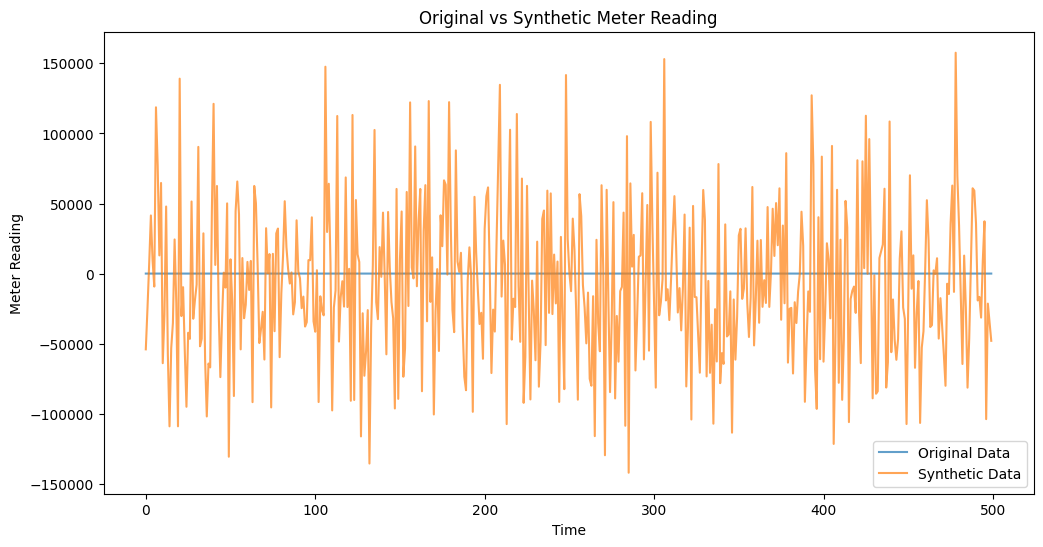

In [29]:
# Sampling function to generate synthetic time series
def sample_diffusion(model, seq_length, num_samples):
    samples = np.random.normal(size=(num_samples, seq_length, 1))  # Start with noise

    for t in tqdm(range(timesteps - 1, 0, -1)):
        t_tensor = np.full((num_samples, seq_length, 1), t)
        predicted_noise = model.predict(samples)

        # Reverse diffusion
        samples = (samples - (1 - alpha[t]) / np.sqrt(1 - alpha_bar[t]) * predicted_noise) / np.sqrt(alpha[t])

        # Add noise except in the final step
        if t > 1:
            z = np.random.normal(size=samples.shape)
            samples += np.sqrt(beta[t]) * z

    return samples

# Generate synthetic data
num_samples = 500  # Number of synthetic samples
synthetic_data = sample_diffusion(diffusion_model, seq_length, num_samples)

# Reshape and denormalize generated data
synthetic_data = synthetic_data.reshape(-1)
synthetic_data = synthetic_data * (max_val - min_val) + min_val

# Clear previous plots if any
plt.close('all')

# Plot original vs synthetic data
plt.figure(figsize=(12, 6))
plt.plot(meter_reading[:500], label="Original Data", alpha=0.7)
plt.plot(synthetic_data[:500], label="Synthetic Data", alpha=0.7)
plt.legend()
plt.title("Original vs Synthetic Meter Reading")
plt.xlabel("Time")
plt.ylabel("Meter Reading")

# Save the plot as an image
plt.savefig("diffusion_output.png", dpi=300)

# Show the plot (optional)
plt.show()

# Close the plot to avoid conflicts
plt.close()